# Part I

## 1.1 Kernel perceptron (Handwritten Digit Classification)

### Question 1. Basic Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

In [2]:
# Imports data
file = open('zipcombo.dat','r')
data = file.read().split('\n')
del data[-1]

In [3]:
# Creates X and y from the data
X = np.zeros((len(data), 256))
y = np.zeros((len(data)))
for i in range(0, len(data)):
    dpoint = data[i].split(" ")
    del point[-1]
    X[i] = np.array(dpoint[1:]).astype(np.float)
    y[i] = np.array(dpoint[0]).astype(np.float)

In [4]:
# Splits data into 80% train and 20% test
def train_test_split(X, y):
    sample = np.random.rand(X.shape[0])
    split = sample < np.percentile(sample, 80)
    X_train = X[split].astype(np.float)
    y_train = y[split].astype(np.float) 
    X_test =  X[~split].astype(np.float) 
    y_test = y[~split].astype(np.float)
    return X_train, y_train, X_test, y_test

In [5]:
# Splits data into 5-folds for cross-validation
def five_fold_split(X):
    s = int(len(X)/5)
    ind = np.arange(len(X)).astype(int)
    train_index = np.zeros((5, len(X) - s))
    test_index = np.zeros((5, s))
    for i in range(0, 5):
        test_index[i] = ind[0+i*s:0+(i+1)*s]
        train_index[i] = np.delete(ind, test_index[i])        
    return train_index, test_index

In [6]:
# Generates table of values
def df_generator(amean, astd, bmean, bstd, indexlabels, columnlabels, shape):
    str1 = np.char.add(np.char.mod('%.5f', amean), "+-")
    str1 = np.char.add(str1,np.char.mod('%.5f', astd))
    str2 = np.char.add(np.char.mod('%.5f', bmean), "+-")
    str2 = np.char.add(str2,np.char.mod('%.5f', bstd))
    df = pd.DataFrame(data = np.array([str1, str2]).reshape(shape), 
                      index = indexlabels,columns = columnlabels)
    return df

In [7]:
# Generates table of values
def df_generator2(amean,astd,bmean,bstd,indexlabels,columnlabels,shape):
    str1 = np.char.add(np.char.mod('%.5f', amean), "+-")
    str1 = np.char.add(str1,np.char.mod('%.5f', astd))
    str2 = np.char.add(np.char.mod('%.5f', bmean), "+-")
    str2 = np.char.add(str2,np.char.mod('%.5f', bstd))
    df = pd.DataFrame(data = np.array([str1, str2]).T,index = indexlabels, 
                      columns = columnlabels)
    return df

In [8]:
# Computes polynomial kernel
def kernel(Xi,Xt,d):
    K = np.dot(Xi, Xt.T)**d
    return K      

In [10]:
# Computes gaussian kernel
def gaussian_kernel(Xi,Xt,c):
    Xiprime = np.sum(Xi**2, axis=1, keepdims=True)
    Xtprime=np.sum(Xt.T**2, axis=0, keepdims=True)
    texp = Xiprime + Xtprime - 2 * np.dot(Xi, Xt.T)
    K = np.exp(-c*texp)
    return K

In [11]:
# Computes y_hat 
def prediction(X, A, t, K, e1): 
    if e1:
        pred = np.dot(A[:,:t], K[t,:t])
    else:
        pred = np.dot(A, K[t,:])
    return pred

In [12]:
# Trains one-versus-all (OVA) perceptron
def train(X_train, y_train, d, epoch, Ktype = "poly"):
    A = np.zeros((len(np.unique(y_train)), len(X_train)))
    total_mistakes = 0 
    if Ktype == "gauss":
        K = gaussian_kernel(X_train, X_train, d)
    else:
        K = kernel(X_train, X_train, d)
        
    e1 = True
    for e in range(epoch):
        epoch_mistakes = 0
        for t in range(len(X_train)):
            y_hat = prediction(X_train, A, t, K, e1)
            ty = np.full((10), -1)
            ty[int(y_train[t])] = 1
            indices = np.where((y_hat*ty) <= 0)[0]
            y_sign = np.sign(y_hat)
            y_sign[np.where(y_sign == 0)] = -1
            A[indices,t] -= y_sign[indices]
            if np.argmax(y_hat) != y_train[t]:
                epoch_mistakes += 1
        e1 = False
        total_mistakes += epoch_mistakes
    return A, (epoch_mistakes)/(len(y_train))

In [13]:
# Tests OVA perceptron
def test(X_train, X_test, y_test, A, d, conf=False, Ktype="poly", track_mistakes=False):
    cmatrix = np.zeros((len(np.unique(y_test)), len(np.unique(y_test))))
    mmatrix = np.zeros(len(X_test))
    mistakes = 0
    if Ktype == "gauss":
        K = gaussian_kernel(X_train, X_test, d)
    else:
        K = kernel(X_train, X_test, d)    
        
    y_hat = np.dot(K.T, A.T)    
    for t in range(1, len(X_test)):          
        if np.argmax(y_hat[t]) != y_test[t]:
            mistakes += 1
            if conf:
                cmatrix[int(y_test[t])][np.argmax(y_hat[t])] += 1
            if track_mistakes:
                mmatrix[t] += 1      
                
    if conf:
        for i in range(0, 10):
            cmatrix[i] = cmatrix[i]/len(np.where(y_test == i)[0])
        return cmatrix
    elif track_mistakes:
        return mmatrix
    else:
        return (mistakes)/len(y_test)

In [14]:
# Runs training and testing for specified number of runs
def train_test(X, y, runs, epochs, d, conf=False, Ktype="poly"):
    Etrain = np.zeros((runs))
    Etest = np.zeros((runs))
    for e in range(0, runs):
        X_train, y_train, X_test, y_test = train_test_split(X, y)
        A, err = train(X_train, y_train, d, epochs, Ktype)
        Etrain[e] = test(X_train, X_train, y_train, A, d, conf, Ktype)
        Etest[e] = test(X_train, X_test, y_test, A, d, conf, Ktype)
    return np.mean(Etrain), np.std(Etrain), np.mean(Etest), np.std(Etest)

In [15]:
Etrain1 = np.zeros((7))
stdtrain1 = np.zeros((7))
Etest1 = np.zeros((7))
stdtest1 = np.zeros((7))
for d in range(1,8):
    Etrain1[d-1], stdtrain1[d-1], Etest1[d-1], stdtest1[d-1] = train_test(X, y, 20, 25, d)

In [16]:
df1 = df_generator2(Etrain1, stdtrain1, Etest1, stdtest1,["d=1", "d=2", "d=3", "d=4", 
                                                          "d=5", "d=6", "d=7"], 
                    ["Train Error", "Test Error"], (7,2))
df1.style

,Train Error,Test Error
d=1,0.06847+-0.00913,0.09847+-0.01043
d=2,0.00032+-0.00023,0.03054+-0.00487
d=3,0.00020+-0.00021,0.02777+-0.00408
d=4,0.00013+-0.00011,0.02610+-0.00308
d=5,0.00012+-0.00008,0.02710+-0.00358
d=6,0.00013+-0.00010,0.02777+-0.00398
d=7,0.00013+-0.00009,0.02825+-0.00329


### Question 2. Cross-validation

In [17]:
# Performs 5-fold cross validation
def cross_validation(X_train, y_train, param, epoch, Ktype="poly"):
    train_in, test_in = five_fold_split(X_train)
    minE = 100
    bestd = 1
    for d in param:
        foldE = 0
        for i in range(0, 5):
            train_index = train_in[i].astype(int)
            test_index = test_in[i].astype(int)
            X_trainfold = X_train[train_index[0]:train_index[len(train_index)-1]]
            y_trainfold = y_train[train_index[0]:train_index[len(train_index)-1]]
            A,_ = train(X_trainfold, y_trainfold, d, epoch, Ktype)
            X_testfold = X_train[test_index[0]:test_index[len(test_index)-1]]
            y_testfold = y_train[test_index[0]:test_index[len(test_index)-1]]
            error = test(X_trainfold, X_testfold, y_testfold, A, d, False, Ktype)
            foldE = foldE + error         
        if foldE < minE:
            bestd = d
            minE = foldE
    return bestd

In [18]:
# Performs cross validation on train data and uses optimal parameter d* to train
# and test full dataset
def cross_train_test(X, y, runs, epoch, param, Ktype="poly"):
    Etest = np.zeros((runs))
    dstar = np.zeros((runs))
    for e in range(0, runs):
        X_train, y_train, X_test, y_test=train_test_split(X, y)
        bestd = cross_validation(X_train, y_train, param, epoch, Ktype)       
        A,_ = train(X_train, y_train, bestd, epoch, Ktype)
        Etest[e] = test(X_train, X_test, y_test, A, bestd, False, Ktype)
        dstar[e] = bestd          
    return Etest, dstar

In [19]:
E2,bestd2 = cross_train_test(X, y, 20, 25, list(range(1, 8)))

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if __name__ == '__main__':


In [20]:
df2 = df_generator(np.mean(bestd2), np.std(bestd2), np.mean(E2), np.std(E2), 
                   [""], ["Mean d*", "Mean Test Error"], (1, 2))
df2.style

,Mean d*,Mean Test Error
,3.90000+-0.83066,0.02769+-0.00362


### Question 3. Confusion matrix

In [21]:
# Performs cross validation on train data and uses optimal parameter d* to train
# and test full dataset; computes confusion matrix for d* on test data and
# percentage of mistakes for each digit
def cross_confusion(X, y, param, runs, epoch):
    cmatrix = np.zeros((runs, 10, 10))
    tmistakes = np.zeros(len(X))
    for e in range(0, runs):
        X_train, y_train, X_test, y_test = train_test_split(X, y)
        bestd = cross_validation(X_train, y_train, param, epoch)
        A,_ = train(X_train, y_train, bestd, epoch)
        cmatrix[e] = test(X_train, X_test, y_test, A, bestd, conf=True)
        tmistakes += test(X_train, X, y, A, bestd, conf=False, track_mistakes=True)       
    return cmatrix, tmistakes

In [22]:
cmatrix, tmistakes = cross_confusion(X, y, list(range(1, 8)), 20, 25)
cmean = np.mean(cmatrix, axis = 0)
cstd = np.std(cmatrix, axis = 0)

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if __name__ == '__main__':


In [23]:
datastr = np.char.add(np.char.mod('%.3f', cmean), "+-")
datastr = np.char.add(datastr, np.char.mod('%.3f', cstd))
df3 = pd.DataFrame(data=datastr,columns=["Predicted Label 0", "Predicted Label 1", "Predicted Label 2", "Predicted Label 3", "Predicted Label 4", "Predicted Label 5", "Predicted Label 6", "Predicted Label 7",
                                     "Predicted Label 8", "Predicted Label 9"], index = ["True Label 0", "True Label 1", "True Label 2", "True Label 3", "True Label 4", "True Label 5", "True Label 6", "True Label 7",
                                     "True Label 8", "True Label 9"])
df3.style                                 

,Predicted Label 0,Predicted Label 1,Predicted Label 2,Predicted Label 3,Predicted Label 4,Predicted Label 5,Predicted Label 6,Predicted Label 7,Predicted Label 8,Predicted Label 9
True Label 0,0.000+-0.000,0.000+-0.001,0.002+-0.003,0.001+-0.002,0.000+-0.001,0.001+-0.002,0.002+-0.002,0.000+-0.001,0.000+-0.001,0.001+-0.001
True Label 1,0.000+-0.001,0.000+-0.000,0.000+-0.001,0.000+-0.001,0.002+-0.002,0.000+-0.000,0.001+-0.002,0.000+-0.001,0.001+-0.003,0.000+-0.001
True Label 2,0.005+-0.007,0.002+-0.004,0.000+-0.000,0.007+-0.006,0.006+-0.005,0.002+-0.003,0.000+-0.001,0.006+-0.004,0.005+-0.005,0.000+-0.000
True Label 3,0.001+-0.002,0.001+-0.003,0.006+-0.004,0.000+-0.000,0.001+-0.002,0.023+-0.010,0.001+-0.002,0.005+-0.004,0.013+-0.008,0.002+-0.003
True Label 4,0.001+-0.002,0.008+-0.006,0.004+-0.005,0.001+-0.002,0.000+-0.000,0.002+-0.004,0.005+-0.004,0.001+-0.002,0.001+-0.002,0.009+-0.006
True Label 5,0.008+-0.007,0.001+-0.002,0.003+-0.004,0.011+-0.011,0.003+-0.004,0.000+-0.000,0.009+-0.007,0.001+-0.002,0.002+-0.004,0.005+-0.006
True Label 6,0.008+-0.008,0.003+-0.005,0.003+-0.005,0.001+-0.002,0.005+-0.006,0.004+-0.006,0.000+-0.000,0.000+-0.000,0.004+-0.004,0.000+-0.001
True Label 7,0.000+-0.001,0.000+-0.001,0.004+-0.005,0.002+-0.003,0.005+-0.006,0.001+-0.003,0.000+-0.000,0.000+-0.000,0.002+-0.004,0.008+-0.009
True Label 8,0.010+-0.008,0.006+-0.005,0.007+-0.008,0.011+-0.009,0.004+-0.004,0.010+-0.009,0.001+-0.003,0.004+-0.005,0.000+-0.000,0.002+-0.005
True Label 9,0.002+-0.003,0.001+-0.002,0.002+-0.004,0.002+-0.003,0.009+-0.007,0.002+-0.005,0.000+-0.001,0.011+-0.008,0.002+-0.004,0.000+-0.000


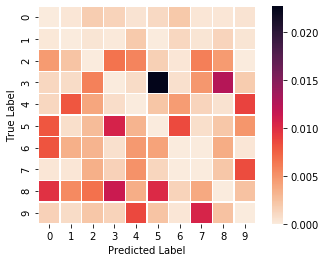

In [24]:
plt.figure()
ax = sns.heatmap(cmean, cmap="rocket_r", square=True, linewidth=0.3)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
y1,y2 = plt.ylim() 
y1 += 0.5 
y2 -= 0.5 
plt.ylim(y1, y2)
plt.show()

### Question 4. 

In [25]:
idx = np.argpartition(tmistakes, -5)[-5:]
top5 = idx[np.argsort((-tmistakes)[idx])]

In [26]:
print(top5)

[5296  796 5124 9013 8284]


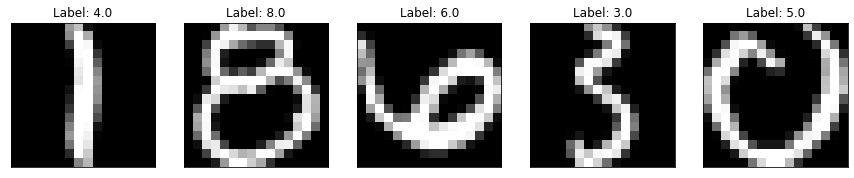

In [27]:
fig, axs = plt.subplots(1, 5, sharey = True, figsize = (15, 15))
for i in range(len(top5)):
    axs[i].title.set_text(("Label: " + np.str(y[top5[i]])))
    axs[i].set(aspect = 'equal')
    axs[i].imshow(np.reshape(X[top5[i]], (16, 16)),
        interpolation = "None",
        cmap = 'gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### Question 5.

Part 1.

In [29]:
median = np.median(distance.cdist(X, X))
print(median)

15.620569627897698


In [30]:
c = 1/median
print(c)

0.06401815195100446


In [31]:
# Parameter initialization
S = np.arange(c-0.06, c+0.01, 0.01)
print(S)

[0.00401815 0.01401815 0.02401815 0.03401815 0.04401815 0.05401815
 0.06401815]


In [32]:
Etrain5 = np.zeros((len(S)))
stdtrain5 = np.zeros((len(S)))
Etest5 = np.zeros((len(S)))
stdtest5 = np.zeros((len(S)))
i = 0
for c in S:
    Etrain5[i], stdtrain5[i], Etest5[i], stdtest5[i] = train_test(X, y, 20, 15, c, False, "gauss")
    i += 1

In [33]:
df5 = df_generator2(Etrain5, stdtrain5, Etest5, stdtest5, ["c=0.004", "c=0.014", "c=0.024", "c=0.034", "c=0.044", "c=0.054", "c=0.064"],
                    ["Train Error","Test Error"], (7, 2))
df5.style

,Train Error,Test Error
c=0.004,0.00095+-0.00065,0.03116+-0.00478
c=0.014,0.00011+-0.00009,0.02382+-0.00403
c=0.024,0.00011+-0.00006,0.02599+-0.00387
c=0.034,0.00007+-0.00008,0.02987+-0.00323
c=0.044,0.00005+-0.00008,0.03441+-0.00369
c=0.054,0.00001+-0.00004,0.03919+-0.00448
c=0.064,0.00000+-0.00000,0.04296+-0.00397


Part 2.

In [35]:
E6, bestd6 = cross_train_test(X, y, 20, 15, S, "gauss")

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if __name__ == '__main__':


In [36]:
df6 = df_generator(np.mean(bestd6), np.std(bestd6), np.mean(E6), np.std(E6), [""],
                   ["Mean c*", "Mean Test Error"], (1, 2))
df6.style

,Mean c*,Mean Test Error
,0.01702+-0.00640,0.02624+-0.00309


### Question 6.

#### Part 1.

In [31]:
# Computes y_hat for one vs. one (OVO) perceptron
def ovoprediction(X, A, t, K, e1): 
    if e1:
        pred = np.dot(A[:t], K[t, :t])
    else:
        pred = np.dot(A, K[t, :])
    return pred

In [32]:
# Trains OVO perceptron
def train_one(X_train, y_train, d, epoch, tK):
    A = np.zeros(len(X_train))
    K = tK
    e1 = True
    pred = np.zeros((len(X_train)))
    for e in range(epoch):
        for i in range(len(X_train)):         
            y_hat = ovoprediction(X_train, A, i, K, e1)
            y_sign = np.sign(y_hat)
            if y_sign == 0:
                y_sign = -1
            if y_hat*y_train[i] <= 0:
                A[i] -= y_sign
        e1 = False        
    return A

In [33]:
# Trains OVO perceptron
def train_all(X_train, y_train, d, epoch):
    k = len(np.unique(y_train))
    A = []
    ind = 0
    K = kernel(X_train, X_train, d)
    for i in range(0, k):
        for j in range(i+1, k):
            indices = np.logical_or(y_train == i, y_train == j)
            ty = y_train[indices]
            ty[ty == j] = -1
            ty[ty == i] = 1
            tx = X_train[indices]
            tK = K[indices]
            tK = tK[:,indices]
            tA = train_one(tx, ty, d, epoch, tK)
            A.append(tA)
    return A

In [34]:
# Tests OVO perceptron
def test_one(A, d, K):
    y_hat = np.dot(K.T, A)
    y_hatsign = np.sign(y_hat)
    y_hatsign[np.where(y_hatsign == 0)] = -1
    return y_hatsign

In [35]:
# Tests OVO perceptron
def test_all(X_train, y_train, X_test, y_test, A, d):
    k = len(np.unique(y_test))
    confidence = np.zeros((int(k*(k-1)/2), len(X_test)))
    ind = 0
    K = kernel(X_train, X_test, d)
    for i in range(0, k):
        for j in range(i+1, k):
            tempy = np.full((len(X_test)), -1)
            tempy[y_test == i] = 1
            tx = X_train[np.logical_or(y_train == i, y_train == j)]
            tK = K[np.logical_or(y_train == i, y_train == j)]
            y_hatsign = test_one(A[ind], d, tK)
            confidence[ind] = y_hatsign
            ind += 1
    kconfidence = np.zeros((k, len(X_test)))
    for i in range(0, k):
        ind = 0
        for j in range(0, k):
            for l in range(j+1, k):
                if i == j:
                    kconfidence[i] += confidence[ind]
                elif i == l:
                    kconfidence[i] -= confidence[ind]
                ind += 1
    predictions = np.zeros(len(X_test))
    for i in range(0, len(X_test)):
        predictions[i] = np.argmax(kconfidence[:, i])
    mistakes = len(np.where(predictions != y_test)[0])
    return mistakes/len(X_test)

In [36]:
# Runs training and testing for specified number of runs
def ovotrain_test(X, y, runs, epochs, d):
    Etrain = np.zeros((runs))
    Etest = np.zeros((runs))
    for e in range(0, runs):
        X_train, y_train, X_test, y_test=train_test_split(X, y)
        A = train_all(X_train, y_train, d, epochs)
        Etrain[e] = test_all(X_train, y_train, X_train, y_train, A, d)
        Etest[e] = test_all(X_train, y_train, X_test, y_test, A, d)
    return np.mean(Etrain), np.std(Etrain), np.mean(Etest), np.std(Etest)

In [ ]:
Etrain7 = np.zeros((7))
stdtrain7 = np.zeros((7))
Etest7 = np.zeros((7))
stdtest7 = np.zeros((7))
for d in range(1, 8):
    Etrain7[d-1], stdtrain7[d-1], Etest7[d-1], stdtest7[d-1] = ovotrain_test(X, y, 20, 30, d)

In [38]:
df7 = df_generator2(Etrain7, stdtrain7, Etest7, stdtest7, ["d=1", "d=2", "d=3", "d=4", "d=5", "d=6", "d=7"],
                    ["Train Error", "Test Error"], (7, 2))
df7.style

,Train Error,Test Error
d=1,0.01490+-0.00494,0.06207+-0.00626
d=2,0.00026+-0.00030,0.03465+-0.00486
d=3,0.00028+-0.00031,0.03191+-0.00393
d=4,0.00049+-0.00094,0.03285+-0.00478
d=5,0.00013+-0.00017,0.03156+-0.00354
d=6,0.00014+-0.00021,0.03460+-0.00354
d=7,0.00021+-0.00035,0.03325+-0.00267


#### Part 2.

In [39]:
# Performs 5-fold cross validation
def ovocross_validation(X_train, y_train, param, epoch):
    train_in, test_in = five_fold_split(X_train)
    minE = 100
    bestd = 1
    foldE = 0
    for d in param:
        for i in range(0, 5):
            train_index = train_in[i].astype(int)
            test_index = test_in[i].astype(int)
            X_trainfold = X_train[train_index[0]:train_index[len(train_index)-1]]
            y_trainfold = y_train[train_index[0]:train_index[len(train_index)-1]]
            C = train_all(X_trainfold, y_trainfold, d, epoch)
            X_testfold = X_train[test_index[0]:test_index[len(test_index)-1]]
            y_testfold = y_train[test_index[0]:test_index[len(test_index)-1]]
            foldE += test_all(X_trainfold, y_trainfold, X_testfold, y_testfold, C, d)
        if foldE < minE:
            bestd = d
            minE = foldE
        foldE = 0
    return bestd

In [40]:
# Performs cross validation on train data and uses optimal parameter d* to train
# and test full dataset
def ovocross_train_test(X, y, runs, epoch, param):
    Etest = np.zeros((runs))
    dstar = np.zeros((runs))
    for e in range(0, runs):
        X_train, y_train, X_test, y_test = train_test_split(X, y)
        bestd = ovocross_validation(X_train, y_train, param, epoch) 
        A = train_all(X_train, y_train, bestd, epoch)
        Etest[e] = test_all(X_train, y_train, X_test, y_test, A, bestd)
        dstar[e] = bestd           
    return Etest, dstar

In [ ]:
E8, bestd8 = ovocross_train_test(X, y, 20, 30, list(range(1, 8)))

In [42]:
df8 = df_generator(np.mean(bestd8), np.std(bestd8), np.mean(E8), np.std(E8), 
                   [""], ["Mean d*", "Mean Test Error"], (1, 2))
df8.style

,Mean d*,Mean Test Error
,3.65000+-1.23592,0.03363+-0.00542
